<a href="https://colab.research.google.com/github/conster303/PFA_ML_Sandbox_CMS/blob/main/UPDATED_PFA_preprocess_PCAk_FRWY_May.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PCA Nevada PFA sandbox

split into three sections


*   Preprocessing
*   PCA decompostion + kmeans
*   Artificial NN Modeling






#Preprocess

## import libraries, preprocessing, and set up drive connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.neural_network import MLPClassifier 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
import tensorflow.keras.backend as K
from scipy.spatial.distance import cdist


from sklearn.decomposition import NMF 
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import normalize

from sklearn.model_selection import cross_val_predict
from mpl_toolkits.axes_grid1 import make_axes_locatable

import random

from scipy.stats import uniform
import pickle
import datetime
import time
import torch
from pathlib import Path
import sys


#If we want to reproduce results/deterministic solutions, pass an integer for random_state

RS = 42 # https://en.wikipedia.org/wiki/42_(number)#The_Hitchhiker's_Guide_to_the_Galaxy
#RS = None

#Set initialization for NMF models 

#init = 'random'
init = 'nndsvd'

#randomness comes from train/test/split as well. 

In [ ]:
#Set up directory where data is stored in your google drive

%cd '/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES'

/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES


In [ ]:
def timeNow():
    '''
    returns current date as a string
    '''
    now = datetime.datetime.now()
    full = "-" + str(now.month) + "-" + str(now.day) + "-" + str(now.year) + \
           '-' + str(now.hour).zfill(2) + ':' + str(now.minute).zfill(2) + ':' + str(now.second).zfill(2)

    return full

To use hdf, pickle, etc., upgrade colab tables

In [ ]:
pip install --upgrade tables

In [ ]:
#Import PFA master hdf file preprocessing
import PFA_preprocessing_february2021 as pfa

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
#To access a gpu (not needed unless for clustering) go to runtime tab, select change runtime type, select GPU then run line to check
tf.config.list_physical_devices('GPU')

[]

## load PFA data

In [ ]:
df_features = pd.read_hdf('./PFA_dataframe_grid_march2021_df.h5', 'df_features')

In [ ]:
#Invert fault recency - now young is high

df_features['FaultRecency'] = df_features['FaultRecency']*-1

In [ ]:
df_features.tail()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,...,FaultRecency_Error,Earthquakes_Error,Heatflow_Error,HorizGravityGradient2_Confidence,HorizMagneticGradient2_Confidence,Hillshade-100m,DEM-30m,Fairway,Domain,T37
1727995,999.0,1723.0,R1000C1724,717077.690182,4.508464e+06,nullValue,12,12,12,NaN,...,0.403113,0.453099,22.451099,0.190986,4,180,1703,-9999.0,0,12
1727996,999.0,1724.0,R1000C1725,717327.690182,4.508464e+06,nullValue,12,12,12,NaN,...,0.403113,0.468096,22.432301,0.203718,4,180,1705,-9999.0,0,12
1727997,999.0,1725.0,R1000C1726,717577.690182,4.508464e+06,nullValue,12,12,12,NaN,...,0.403113,0.468096,22.413500,0.190986,4,180,1703,-9999.0,0,12
1727998,999.0,1726.0,R1000C1727,717827.690182,4.508464e+06,nullValue,12,12,12,NaN,...,0.403113,0.468096,22.394600,0.165521,4,180,1702,-9999.0,0,12
1727999,999.0,1727.0,R1000C1728,718077.690182,4.508464e+06,nullValue,12,12,12,NaN,...,0.403113,0.468096,22.375601,0.165521,4,180,1702,-9999.0,0,12


In [ ]:
df_SSlookup = pd.read_hdf('PFA_structuralSettingsLookup_october2020_df.h5', 'df_SSLookup')
df_SSlookup.head()

,Local_polygon_Id,Local_polygon_overlap_Id,Label,Label2,Label3
0,1,1,AZ,NaN,NaN
1,2,2,FT,NaN,NaN
2,3,3,SO,NaN,NaN
3,4,4,SO,NaN,NaN
4,7,7,SO,NaN,NaN


In [ ]:
#Dataframe with attributes for KGS/wells, names, temperatue values, blind label, Nameplate capacity, well type, and depth
url = 'https://raw.githubusercontent.com/connormacs/Geothermal-Rising-ML-GeoStats-Workshop/main/PFA_TSITES.csv'

df_Tsite_GIS = pd.read_csv(url)
df_Tsite_GIS.head()

,Id,QuaternaryFaultDensity,HorizGravityGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency,Earthquakes,HorizMagneticGradient2,Heatflow,...,TrainCodePos,TrainCodePosT130,TrainCodePosT37,NAME,MAX_MAXT,Blind,POWER,E_utm83,N_utm83,Depth(m)
0,6,1.285103,-1.179981,1.327701,-0.875585,-1.595637,0.116588,0.187495,1.161904,0.765071,...,1,12,1,Grant View Hot Springs,53.0,no,0.0,325910.7938,4261123.388,NaN
1,78,0.200934,3.224230,0.042698,0.925116,-0.450002,-0.557711,0.779572,-0.095253,-1.670693,...,1,1,12,Bacon Flat,130.0,yes,0.0,626240.6513,4262689.377,NaN
2,27,0.530642,0.346868,1.670390,2.105045,0.760399,-0.140574,2.492251,1.213427,0.415872,...,1,12,1,Hawthorne 1,97.0,yes,0.0,356239.0985,4263285.061,NaN
3,82,2.520683,-0.845162,-0.276014,-0.920538,-1.178281,-0.632902,1.053704,-0.589872,-1.448916,...,1,1,12,Hot Creek Ranch Hot Spr,160.0,no,0.0,555117.5865,4263714.281,NaN
4,31,0.328629,3.224230,0.004236,0.698215,-0.420560,-0.177550,0.706009,-0.899009,-1.639976,...,1,12,1,Blue Eagle Springs,41.0,no,0.0,628207.4400,4269285.723,NaN


## preprocess data

In [ ]:
extraFeatures = ['GravityDensity', 'MagneticDensity', 
                 'GeochemistryTemperature2',
                 'Silica_Distance', 'TufaOrTravertine_Distance',
                 'DEM-30m', 'FavorableStructuralSettings_Distance']

# extraFeatures = None

Call pfa preprocessing, N for numerical and C for categorical.

N is 0-1.2 scoring for 'Local-StructuralSetting', and C is 19 different structures 1hot encoded (~7 major and 12 hybrid).

The data is reduced (z-score) and scaled (standard). 

Distance from faults = distance_edt, also have option to change to gaussian filter 'gaussianFilter'

In [ ]:
transformDict = {'features': ['Local-StructuralSetting',
                              'Local-QuaternaryFaultRecency',
                              'Local-QuaternaryFaultSlipDilation', 
                              'Local-QuaternaryFaultSlipRate',
                              'QuaternaryFaultTraces'], 
                 'transforms': ['gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'distance_edt'], 
                 'params': [10, 10, 10, 10, 20]}

# transformDict = {'features': ['QuaternaryFaultTraces'], 
#                  'transforms': ['distance_edt'], 
#                  'params': [20]}

dfn, dfInfo, nullIndexes, scaler = pfa.preprocess_features_AllNumerical(df_features,
                                                                          transformFeatures=transformDict,
                                                                          extraFeatures=extraFeatures, 
                                                                          prescaleFeatures=True, withMean=True)

# dfn, dfInfo, nullIndexes, scaler = pfa.preprocess_features_LocalNumerical(df_features, 
#                                                                           resetLocal=None,
#                                                                           transformFaultTraces='distance_edt',
#                                                                           extraFeatures=extraFeatures, 
#                                                                           prescaleFeatures=True)

# dfc, dfInfoc, nullIndexesc, scalerc = pfa.preprocess_features_LocalCategorical(df_features.copy(), df_SSlookup,
#                                                                                resetLocal=None,
#                                                                                transformFaultTraces='distance_edt',
#                                                                                extraFeatures=None,
#                                                                                prescaleFeatures=True)

In [ ]:
#Can change name
#dfn = dfn.rename({'QuaternaryFaultTraces':'QuaternaryFaultDistance'},axis=1)
#dfN = dfN.rename({'QuaternaryFaultTraces':'QuaternaryFaultDensity'},axis=1)
#dfC = dfC.rename({'QuaternaryFaultTraces':'QuaternaryFaultDensity'},axis=1)


In [ ]:
Xall = dfn.copy()
columns = Xall.columns.to_list()
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [ ]:
featureSets = [

# MASTER SET 1
################################
# featureSet = 0
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 1alt: master set 1 with new gravity/magnetic features substituted
################################
# featureSet = 1
################################
['QuaternaryFaultTraces',
 'GravityDensity',
 'MagneticDensity',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2: master set 1 + all local
################################
# featureSet = 2
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 3: master set 1 + geochemistry direct evidence 
################################
# featureSet = 3
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 4: union of master sets 2 and 3
################################
# featureSet = 4
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 2a: master set 1 + local structural setting
################################
# featureSet = 5
################################
['Local-StructuralSetting',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2b: master set 1 + favorable structural settings
################################
# featureSet = 6
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 4b: union of master sets 2b and 3
################################
# featureSet = 7
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 1m: master set 1 minus geodetic strain rate
################################
# featureSet = 8
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
# 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
# MASTER SET 1n: master set 1 minus dem-30m
################################
# featureSet = 9
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
# 'DEM-30m',
],

[
  'GeodeticStrainRate',
 'Earthquakes'
]


]

len(featureSets)

11

In [ ]:
feature_set = 2

columns = featureSets[feature_set]

#update the feature set number so it is 1-9 for presentation
feature_set = feature_set+1

columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

In [ ]:
dfInfo['T37'] = df_features['T37']
dfInfo['Domain'] = df_features['Domain']

dfInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,0.0,0.0,R1C1,286327.690182,4.258714e+06,notNull,12,12,12,9.0,82070.110132,61.0,34166.449170,22.0,122848.502942,0,0,12,1
1,0.0,1.0,R1C2,286577.690182,4.258714e+06,notNull,12,12,12,9.0,81993.349012,61.0,34115.759156,22.0,122726.185082,0,0,12,1
2,0.0,2.0,R1C3,286827.690182,4.258714e+06,notNull,12,12,12,9.0,81917.278930,61.0,34066.828392,22.0,122604.254961,0,0,12,1
3,0.0,3.0,R1C4,287077.690182,4.258714e+06,notNull,12,12,12,9.0,81841.901813,61.0,34019.664470,22.0,122482.713736,0,0,12,1
4,0.0,4.0,R1C5,287327.690182,4.258714e+06,notNull,12,12,12,9.0,81767.219578,61.0,33974.274746,22.0,122361.562567,0,0,12,1


## select benchmark sites based on trainCode distance

Select trainCode=1: for 83+ and 62- or trainCode=2: 415+ and 310-


In [ ]:
X, y, XyInfo = pfa.makeBenchmarks(dfn, dfInfo, nullIndexes, 
                                          trainCode=1, randomize=True, balance=False)

Number of (+):  83   ; Number of (-):  62


In [ ]:
# X, y, XyInfo = pfa.makeBenchmarks(dfC, dfInfoC, nullIndexesC, 
#                                   trainCode=1, randomize=True, balance=True)

In [ ]:
print( X.shape, y.shape)

(145, 20) (145,)


In [ ]:
X.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
1058756,-0.532810,-0.586230,-0.402901,-0.584993,1.214709,0.219336,-0.466218,-1.565202,2.211996,1.267337,0.865215,-0.521839,0.150755,1.667016,1.645851,-0.185826,0.194328,0.675976,-0.106244,1.758735
341769,-0.433777,-0.440164,-0.370513,-0.447364,-0.503780,-0.914771,-1.043273,-0.601991,-0.402264,-0.367175,-0.520359,0.444985,-1.643686,0.282704,1.187716,-0.185826,1.737359,-1.023558,-0.260997,-0.497252
1143828,-0.532421,-0.585677,-0.402778,-0.584411,1.711915,-0.838098,-0.486827,-1.319330,0.343495,-0.551157,1.081252,-1.352377,0.081102,1.667016,0.156912,-0.185826,0.598771,0.015650,-0.072714,1.034225
1091173,1.130973,0.598776,-0.140273,0.661015,-0.707038,-0.328935,-0.723832,0.556974,-0.665820,-0.057607,0.975851,-0.283636,2.402299,-0.524811,0.844115,-0.185826,-0.345039,-0.009807,-0.408012,-1.547475
931271,1.551443,2.380942,0.255009,2.536613,-0.399604,2.305629,-0.754745,-1.018777,0.428161,-0.099663,0.536022,-1.352377,-0.406033,-1.216966,0.385979,6.101908,1.135209,-1.742602,0.038193,-1.461277


In [ ]:
y

1058756    0
341769     0
1143828    0
1091173    1
931271     1
          ..
749308     0
1481915    1
572227     1
201944     0
1507458    1
Name: labels, Length: 145, dtype: int64

In [ ]:
XyInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
1058756,612.0,1220.0,R613C1221,591327.690182,4.411714e+06,notNull,1,12,12,76.0,88395.671924,48.0,15798.692259,47.0,86.332072,0,0,12,4
341769,197.0,1353.0,R198C1354,624577.690182,4.307964e+06,notNull,1,12,12,13.0,45304.919500,44.0,12681.853562,43.0,79.656437,0,0,12,4
1143828,661.0,1620.0,R662C1621,691327.690182,4.423964e+06,notNull,1,12,12,14.0,84190.196565,25.0,13400.822555,1.0,104.567213,0,0,12,4
1091173,631.0,805.0,R632C806,487577.690182,4.416464e+06,notNull,12,1,1,65.0,74.884570,65.0,74.884570,54.0,68262.894212,128,0,12,3
931271,538.0,1607.0,R539C1608,688077.690182,4.393214e+06,notNull,12,1,12,14.0,109850.542251,26.0,17.147495,11.0,12809.329220,48,0,1,4


In [ ]:
#Create Dataframe with training site info
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
XyInfo.reset_index(drop=True, inplace=True)

Tsite= pd.concat([X,XyInfo],axis=1).reset_index(drop=True)
Tsite

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,...,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,-0.532810,-0.586230,-0.402901,-0.584993,1.214709,0.219336,-0.466218,-1.565202,2.211996,1.267337,...,76.0,88395.671924,48.0,15798.692259,47.0,86.332072,0,0,12,4
1,-0.433777,-0.440164,-0.370513,-0.447364,-0.503780,-0.914771,-1.043273,-0.601991,-0.402264,-0.367175,...,13.0,45304.919500,44.0,12681.853562,43.0,79.656437,0,0,12,4
2,-0.532421,-0.585677,-0.402778,-0.584411,1.711915,-0.838098,-0.486827,-1.319330,0.343495,-0.551157,...,14.0,84190.196565,25.0,13400.822555,1.0,104.567213,0,0,12,4
3,1.130973,0.598776,-0.140273,0.661015,-0.707038,-0.328935,-0.723832,0.556974,-0.665820,-0.057607,...,65.0,74.884570,65.0,74.884570,54.0,68262.894212,128,0,12,3
4,1.551443,2.380942,0.255009,2.536613,-0.399604,2.305629,-0.754745,-1.018777,0.428161,-0.099663,...,14.0,109850.542251,26.0,17.147495,11.0,12809.329220,48,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,-0.246651,-0.315763,-0.348927,-0.328903,0.569889,0.345583,-0.940228,-0.455208,-1.238783,-0.898591,...,76.0,51663.626124,28.0,5181.968910,27.0,46.363721,0,0,12,4
141,0.269240,0.936150,1.020324,0.856462,-1.064303,0.239243,0.935204,-0.805818,1.418586,2.351693,...,1.0,18590.956907,31.0,80.072841,19.0,29325.476497,295,0,1,4
142,-0.015105,-0.176779,-0.321192,-0.197309,1.461942,1.636441,1.728656,1.260158,-0.095780,0.264404,...,21.0,100.788271,21.0,100.788271,61.0,19964.267217,89,0,12,1
143,0.090442,-0.093303,-0.304534,0.348457,1.248917,0.730876,-0.435304,0.067155,-0.824268,0.757494,...,13.0,42286.478424,43.0,14405.203226,51.0,136.034939,0,0,12,4


## Create a dataframe with all the normalized data
combines dfN and dfNInfo and includes domains, used for cluster projection into fairway and for fairway NMF/PCA

In [ ]:
#Create a dataframe with all the normalized data

Info = pd.concat([dfn,dfInfo],axis=1,sort=False)
Info.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,...,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,-0.523680,-0.568900,-0.399442,-0.568584,0.521096,-0.506811,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,82070.110132,61.0,34166.449170,22.0,122848.502942,0,0,12,1
1,-0.523768,-0.569068,-0.399476,-0.568743,0.521096,-0.192541,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,81993.349012,61.0,34115.759156,22.0,122726.185082,0,0,12,1
2,-0.523942,-0.569398,-0.399542,-0.569055,0.521096,0.115757,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,81917.278930,61.0,34066.828392,22.0,122604.254961,0,0,12,1
3,-0.524196,-0.569881,-0.399638,-0.569513,0.524190,0.339483,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,81841.901813,61.0,34019.664470,22.0,122482.713736,0,0,12,1
4,-0.524525,-0.570503,-0.399762,-0.570102,0.533434,0.436512,-1.146319,1.738459,-0.630559,-0.640521,...,9.0,81767.219578,61.0,33974.274746,22.0,122361.562567,0,0,12,1


In [ ]:
#Check how many domains there are, should be 5 (4 plus study area)
print (Info['Domain'].unique())

[1 3 4 0 2]


(1728000,)


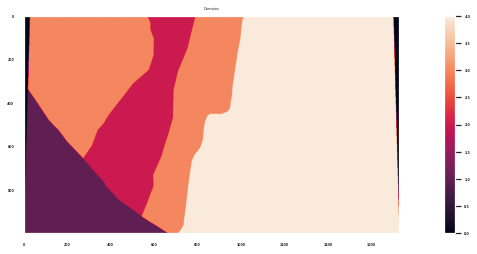

In [ ]:
SD = Info['Domain'].to_numpy().astype(float)
print(SD.shape)
plt.rc('figure', figsize=(16,4))
SD =np.reshape(SD,(1000,1728))
#flip it so it is right side up
SD = np.flipud(SD)
#np.fliplr
#SD =np.reshape(SD,(1263,1344))
plt.imshow(SD)
plt.title('Domains')
plt.colorbar()
plt.grid(False)
# 1 wl, 2 cnsb, 3 wgb, 4 carb

## Explore data at training sites, structures and domains

In [ ]:
##############################
#Tsites
Tsite_Set = Tsite.copy()[columns]

Tsite_Set.rename(columns = {'QuaternaryFaultTraces':'QuaternaryFaultDistance'}, inplace = True)
Tsite_Pos = Tsite[Tsite['TrainCodePos']!=12]
Tsite_Neg = Tsite[Tsite['TrainCodePos']==12]
Tsite_PosLOW = Tsite_Pos[Tsite_Pos['TrainCodePosT130']==12] #lower  pos
Tsite_PosBM = Tsite_Pos[Tsite_Pos['TrainCodePosT130']!=12] #Benchmark  pos

##############################
#Structures

#Select data within structures 
df_Struct = Info.copy().loc[Info['Local_polygon_Id'] != 0] 
#take mean values
df_mean_struct = df_Struct.groupby('Local_polygon_Id').mean()

#Reindex structures, there may be 384 total, but they are grouped so that there are actuall 365 and 19 hybrid 
df_mean_struct.index = range(len(df_mean_struct))
df_mean_struct['Label'] = df_SSlookup['Label']

Struc_Set = df_mean_struct.copy()[columns]

#Labeled dataframe of which structures host Known Geothermal Systems to append after groupby transformation
yStruct = (df_Struct.groupby(['Local_polygon_Id'])['TrainCodePos'].min())
yStruct.index = range(len(yStruct))
yStruct = pd.DataFrame(yStruct) 

 # I use 0 instead of 
yStruct['TrainCodePos'].replace({12:0, 4:0,9:0,10:0,6:0,8:0,7:0}, inplace=True)
#Replace/update TrainCodePos values 
df_mean_struct = df_mean_struct.drop(['TrainCodePos'], axis = 1)
yStruct.rename(columns = {'TrainCodePos':'TrainCodePos2'}, inplace = True) #Update name to have a 2
df_mean_struct['TrainCodePos'] = yStruct['TrainCodePos2']
##############################
#Domains

WL = Info[Info['Domain'] == 1]
CNSB =  Info[Info['Domain'] == 2]
WGB =  Info[Info['Domain'] == 3]
CAQ = Info[Info['Domain'] == 4]

FRWY_Set = Info.copy()[columns]
FRWY_Set.rename(columns = {'QuaternaryFaultTraces':'QuaternaryFaultDistance'}, inplace = True)

In [ ]:
normal_data = np.random.randn(10, 12)
ax = sns.heatmap(normal_data, center=0, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

NameError: ignored

In [ ]:
corr = np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

In [ ]:
import seaborn as sns
sns.set(font_scale = 0.80)
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":10,"axes.labelsize":10},style="white")
FRWY_correlation_mat = FRWY_Set.corr()
#sns.set(font_scale = 1.3)

mask = np.triu(np.ones_like(FRWY_correlation_mat, dtype=bool))

mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  ax = sns.heatmap(FRWY_correlation_mat, mask = mask, annot = True, yticklabels='auto', linewidths=.95, cmap = 'viridis',annot_kws={"size": 8}, fmt='.1g')
  #ax.fontweight='bold'
  ax.set_aspect("equal")
  ax.tick_params(left=True, bottom=True)

#ax.tick_params(labelrotation=75,left=True, width=-2,)

plt.title('Fairway Correlation Matrix - Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');
plt.show()
plt.tight_layout()
plt.savefig('March_Figs/PCA_FRWY_PearsCorrMatrix ' + str(feature_set) + '.png') 


In [ ]:
TSITE_correlation_mat = Tsite_Set.corr()
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.labelsize":20},style="white")
FRWY_correlation_mat = FRWY_Set.corr()
sns.set(font_scale = 1.3)
ax = sns.heatmap(TSITE_correlation_mat, annot = True, linewidths=.95, cmap = 'viridis',annot_kws={"size": 12}, fmt='.1g')

ax.fontweight='bold'
ax.set_aspect("equal")

plt.title('TSITE Correlation Matrix - Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');


plt.savefig('March_Figs/PCA_TSITE_PearsCorrMatrix ' + str(feature_set) + '.png') 
plt.show()
plt.tight_layout()

#PCA Analysis

## PCA with Training Sites


In [ ]:
from sklearn.decomposition import PCA
n = len(Tsite_Set.columns)
pcamodel = PCA(n_components=n)


pcaTsites = pcamodel.fit_transform (Tsite_Set)

score = pcaTsites[:,0:2]

score[:,0].shape

xs = score[:,0]
ys = score[:,1]

In [ ]:
#Explained variance calcuation
def get_variance(model, data, scorer=metrics.explained_variance_score):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data)) #Transform data back to original space
    return scorer(data, prediction)

#Get another score? https://scikit-learn.org/stable/modules/model_evaluation.html

#Start at 2 and go up to 8
K = range(2,n)

Variance= []
Reconstruction_err = []
Sill_score = []
for k in K:
    pca = PCA(n_components=k).fit(Tsite_Set)
    Variance.append(get_variance(pca,Tsite_Set))
    clusterer = KMeans(n_clusters=k,random_state = RS)
    pca_score = pca.fit_transform(Tsite_Set)
    pred = clusterer.fit_predict(pca_score)
    score = silhouette_score(pca_score, pred)
    Sill_score.append(score)
print(Variance)

ValueError: ignored

In [ ]:
plt.rc('figure', figsize=(22, 8))

#plt.suptitle('Picking Signals (p) for NMF',fontsize = 38,fontweight='bold')


plt.subplot(121)

plt.bar(K,Variance)
plt.plot(K, Variance, c='r',marker='o')

plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Total Explained Variance (0 - 1)',fontsize = 18,fontweight='bold')

plt.title('PCA Signal vs Variance Explained- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

#plt.legend(fontsize = 18)
plt.grid(True)


plt.subplot(122)

plt.plot(K,Sill_score,c='r',marker='o')
plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Sillhouette Score (-1 - 1)',fontsize = 18,fontweight='bold')

plt.title('PCA Signal vs Silhouette Width- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

plt.savefig('March_Figs/PCA/TSITES/PCA_TSITE_find_p_Set ' + str(feature_set) + '.png') 

In [ ]:
pcamodel.explained_variance_ratio_

#Truncate PCA's if first 4 account for most of the variance
var_ratio1 = float(str(round(pcamodel.explained_variance_ratio_[0]*100, 2)))
var_ratio2 = float(str(round(pcamodel.explained_variance_ratio_[1]*100, 2)))
var_ratio3 = float(str(round(pcamodel.explained_variance_ratio_[2]*100, 2)))
var_ratio4 = float(str(round(pcamodel.explained_variance_ratio_[3]*100, 2)))

var_ratio1+var_ratio2+var_ratio3+var_ratio4

In [ ]:
pcaTsite_df = pd.DataFrame(pcaTsites,columns=[ "PC"+str(TSite_Set_Group) for TSite_Set_Group in range(1,pcamodel.n_components_+1)])
pcaTsite_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,1.331641,2.088904,-0.460008,0.031655,1.639697,-2.174269,1.368458,0.466063,0.979837,-0.824519,0.592557,-1.226064,0.285002,-0.406281
1,0.874385,-0.553516,0.275952,-0.902815,0.018327,-1.095563,-1.454832,0.423894,0.629346,0.441240,-0.520091,0.263986,0.207861,0.096997
2,-1.774624,-1.576152,-1.667972,-0.385788,-0.501184,0.471118,-0.937773,0.345412,-0.777117,-0.064185,-0.378914,-0.452308,-0.079357,0.148006
3,1.103797,2.692155,-1.526970,-1.304173,0.515865,0.073647,-0.811467,1.035157,-0.160232,0.055438,-0.252115,1.034108,-0.106423,0.010359
4,-1.910711,-1.242345,-2.254051,-0.982407,-0.676604,0.533899,-0.806552,-0.944114,-0.796452,-1.137036,0.033252,0.082730,-0.071676,-0.112438


In [ ]:
from sklearn.cluster import KMeans

nCluster = 3

Kmean = KMeans(n_clusters=nCluster,init = 'k-means++', verbose = 0, random_state=RS)

Kmean.fit(pcaTsite_df[['PC1','PC2','PC3','PC4']])

KMeans(n_clusters=3, random_state=42)

In [ ]:
RS

42

In [ ]:
Kmean.labels_ 

array([2, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 0,
       0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1,
       2, 2, 0, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 2, 0, 1, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 2], dtype=int32)

In [ ]:
#Join data into df_out data frame
centers = np.copy(Kmean.cluster_centers_)

Labels = Kmean.labels_

df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([pcaTsite_df,Tsite, df_labels], axis=1, sort=False)

print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
print('', file=sys.stdout, flush=True)

Last 5 rows of df_out:
          PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10      PC11      PC12      PC13      PC14  Local-StructuralSetting  Local-QuaternaryFaultRecency  Local-QuaternaryFaultSlipDilation  Local-QuaternaryFaultSlipRate  QuaternaryFaultTraces  HorizGravityGradient2  HorizMagneticGradient2  GeodeticStrainRate  QuaternarySlipRate  FaultRecency  FaultSlipDilationTendency2  Earthquakes  Heatflow  GravityDensity  MagneticDensity  GeochemistryTemperature2  Silica_Distance  TufaOrTravertine_Distance   DEM-30m  FavorableStructuralSettings_Distance    row  column      id_rc      X_83UTM11     Y_83UTM11 NullInfo  TrainCodeNeg  TrainCodePos  TrainCodePosT130  PosSite130_Id  PosSite130_Distance  PosSite_Id  PosSite_Distance  NegSite_Id  NegSite_Distance  Local_polygon_Id  Local_polygon_overlap_Id  T37  Domain  KMeansGrp  Grp0_CntrX  Grp0_CntrY  Grp1_CntrX  Grp1_CntrY
140 -2.079052  1.322500  1.077360 -0.248828  0.103960  0.677060 

In [ ]:
#Groups for positive sites
group1 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)]
label1 = 'Positive T-Site - Cluster 1: ' + str(len(group1))
group2 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)]
label2 = 'Positive T-Site - Cluster 2: ' + str(len(group2))
group3 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)]
label3 = 'Positive T-Site - Cluster 3: ' + str(len(group3))
group4 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 3)]
label4 = 'Positive T-Site - Cluster 4: ' + str(len(group4))

#Groups for negative sites 
group5 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]
label5 = 'Negative T-Site - Cluster 1: ' + str(len(group5))
group6 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]
label6 = 'Negative T-Site - Cluster 2: ' + str(len(group6))
group7 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]
label7 = 'Negative T-Site - Cluster 3: ' + str(len(group7))
group8 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 3)]
label8 = 'Negative T-Site - Cluster 4: ' + str(len(group8))


In [ ]:
#ADD ELLIPSES
def plot_kmeans(kmeans, X, n_clusters=3, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    #ax.axis('equal') #equal makes them circles
    #ax.set_ylim(-5000,7000)
    #ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_ 
    radii = [cdist(X[labels == i], [center]).mean()
             for i, center in enumerate(centers)]
    #for c, r in zip(centers, radii):
    c1 = 'cyan'
    c2 = 'yellowgreen'
    c3 = 'violet'
    c4 = 'yellowgreen'
   # ax.add_patch(plt.Circle(centers[0], radii[0], fc='white',ec =c4, lw=3, alpha = 0.3, zorder=.1))
    ax.add_patch(plt.Circle(centers[1], radii[1], fc='white',ec =c2, lw=3, alpha = 0.3, zorder=.1))
    ax.add_patch(plt.Circle(centers[2], radii[2], fc='white',ec =c3, lw=3, alpha = 0.3, zorder=.1))
    ax.add_patch(plt.Circle(centers[3], radii[3], fc='white',ec =c1, lw=3, alpha = 0.3, zorder=.1))


In [ ]:
#Colors for plots
c1 = 'violet'
c2 = 'yellowgreen'
c3 = 'cyan'
c4 = 'red'

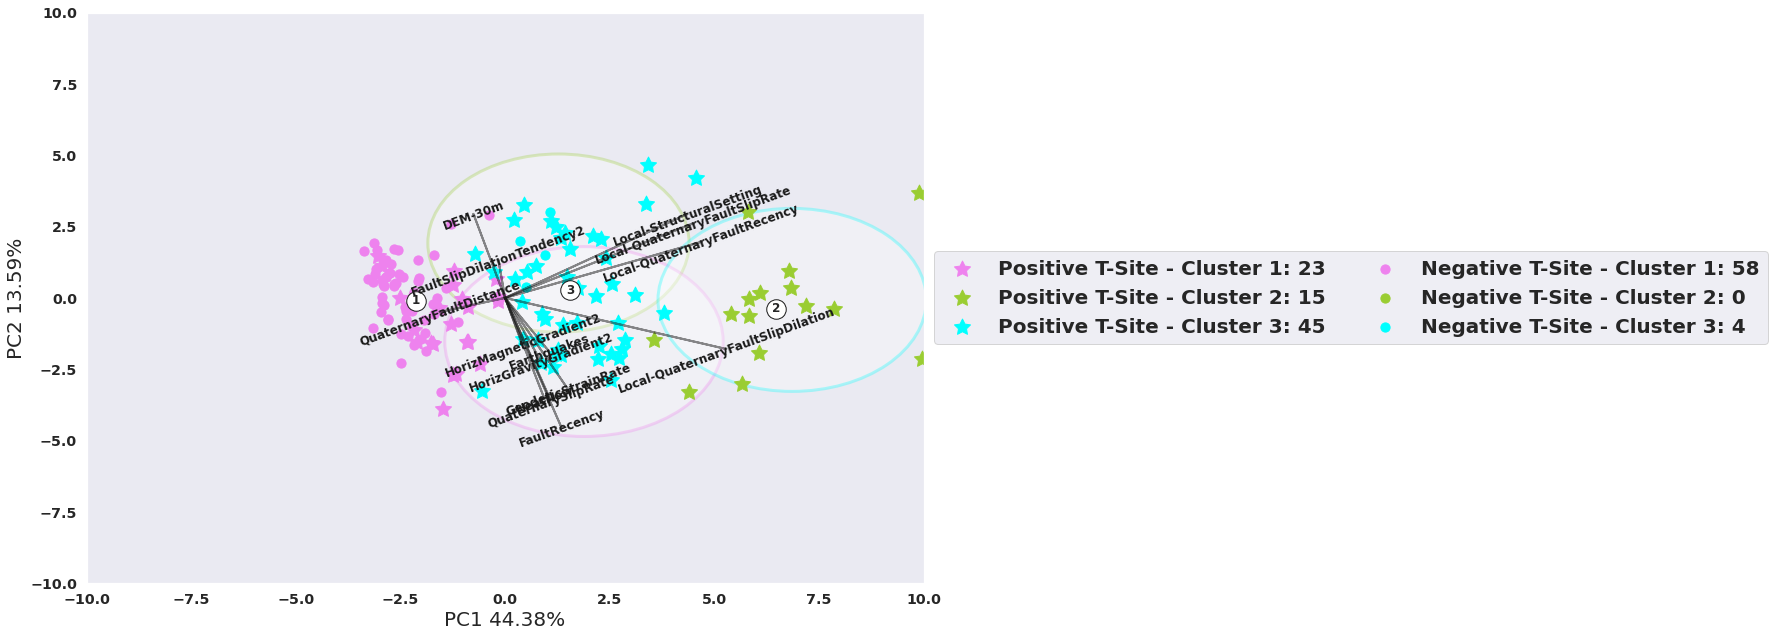

In [ ]:
fig= plt.figure(figsize=(15,10.5)) 
#plot kmeans data
from scipy.spatial.distance import cdist

plt.scatter(group1['PC1'], group1['PC2'],c=c1,s=285,marker=(5, 1), label=label1)
plt.scatter(group2['PC1'], group2['PC2'], c=c2,s=285, marker=(5, 1),label=label2)            
plt.scatter(group3['PC1'], group3['PC2'],  c=c3,s=285, marker=(5, 1),label=label3)
#plt.scatter(group4['PC1'], group4['PC2'],  c=c4,s=285, marker=(5, 1),label=label4)
            
plt.scatter(group5['PC1'], group5['PC2'], c=c1,s=85, marker='o', label=label5)   
plt.scatter(group6['PC1'], group6['PC2'], c=c2,s=85, marker='o',label=label6)
plt.scatter(group7['PC1'], group7['PC2'],  c=c3,s=85, marker='o',label=label7)            
#plt.scatter(group8['PC1'], group8['PC2'],  c=c4,s=85, marker='o',label=label8)            

angle = 20

#ADD VECTORS
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*10, coeff[i,1]*10,color = 'k',alpha = 0.5, lw = 2 ) #MULTIPLY BY 10
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 10.00, coeff[i,1] * 10.00, labels[i],color = 'k',horizontalalignment='center', verticalalignment='center_baseline', rotation=angle, rotation_mode='anchor', fontsize=12,fontweight='bold')
 
    plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
    plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)

#Plot Kmeans center locations
plt.scatter(centers[:,0] , centers[:,1] , s = 380, marker='o', edgecolors='k',color = 'white')
for i in range(centers.shape[0]):
    plt.text(centers[i,0], centers[i,1], str(i+1),fontsize=12,fontweight='bold',horizontalalignment='center', verticalalignment='center')

#call ellipse plot function
kmeans = KMeans(n_clusters=4, random_state=RS)
plot_kmeans(kmeans, pcaTsites) # hash out to turn off ellipses

plt.xlim([-10, 10])
plt.ylim([-10, 10]) 

plt.grid()

myplot(pcaTsites[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(Tsite_Set.columns))
ncols = 2
plt.legend(scatterpoints=1, ncol=ncols, loc='center left',bbox_to_anchor=(1, 0.5),fontsize=20)

#plt.savefig('March_Figs/PCA/TSITES/PCA_TSITE' + str(nCluster) + 'BIPLOT' +'Set' + str(feature_set)  + '.png')

### Look at statistics for each cluster

Manually set up constant of the x,y location of the center of each cluster to multiply pca components by to see loading values at centroid

In [ ]:
Centers = centers

C1_Center = Centers[0:1].T
C2_Center = Centers[1:2].T
C3_Center = Centers[2:3].T
C4_Center = Centers[3:4].T

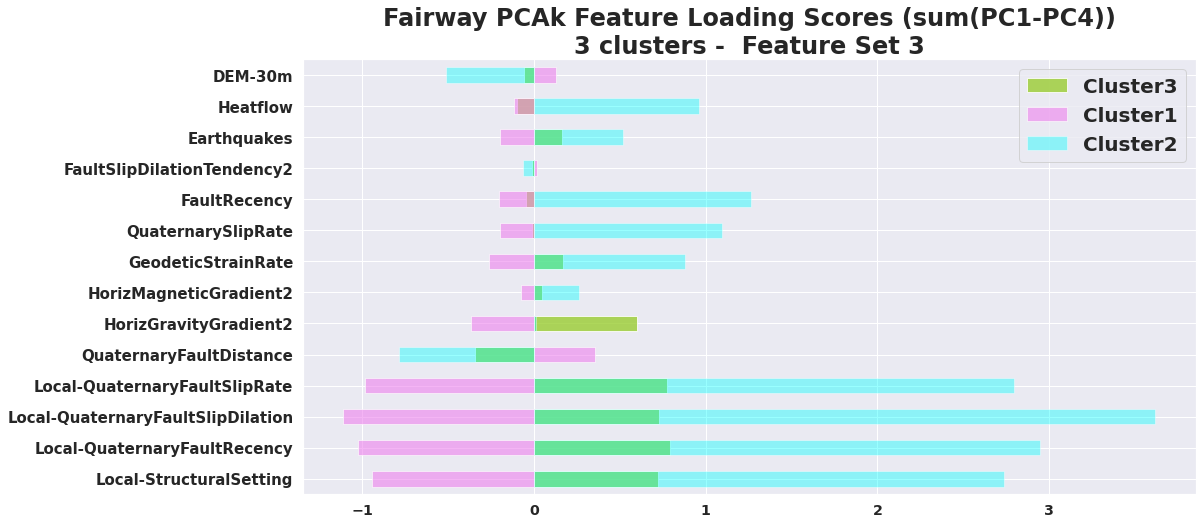

In [ ]:
#Find the values for PC1-PC4 for each cluster

plt.rc('figure', figsize=(16, 8))

#plt.suptitle('Picking Signals (p) for NMF',fontsize = 38,fontweight='bold')



#select cluster to multiply coefficients by 
Cluster1_results = pcamodel.components_[0:4 :]*C1_Center
Cluster2_results = pcamodel.components_[0:4 :]*C2_Center
Cluster3_results = pcamodel.components_[0:4 :]*C3_Center
#Cluster4_results = pcamodel.components_[0:4 :]*C4_Center

df_columns = ['PC1','PC2','PC3','PC4']

#set rows to be the feature columns
rows = list(FRWY_Set.columns)
C1_DF = pd.DataFrame(Cluster1_results.T,rows,df_columns)
C1_DF['Cluster1'] = (C1_DF['PC1'])+(C1_DF['PC2']+C1_DF['PC3']+C1_DF['PC4'])

C2_DF = pd.DataFrame(Cluster2_results.T,rows,df_columns)
C2_DF['Cluster2'] = (C2_DF['PC1'])+(C2_DF['PC2']+C2_DF['PC3']+C2_DF['PC4'])

C3_DF = pd.DataFrame(Cluster3_results.T,rows,df_columns)
C3_DF['Cluster3'] = (C3_DF['PC1'])+(C3_DF['PC2']+C3_DF['PC3']+C3_DF['PC4'])

#C4_DF = pd.DataFrame(Cluster4_results.T,rows,df_columns)
#C4_DF['Cluster4'] = (C4_DF['PC1'])+(C4_DF['PC2']+C4_DF['PC3']+C4_DF['PC4'])


c1 ='violet'
c2 ='yellowgreen' 
c3 ='cyan' 

#plt.subplot(221)

ax = C3_DF['Cluster3'].plot(kind='barh',color = c2,alpha =0.8)
ax = C1_DF['Cluster1'].plot(kind='barh',color = c1,alpha = 0.6)
ax = C2_DF['Cluster2'].plot(kind='barh',color = c3,alpha = 0.4)
#ax = C4_DF['Cluster4'].plot(kind='barh',color = c4,alpha = 0.5)

ax.set_yticklabels(FRWY_Set.columns, fontweight = 'bold',fontsize=15)
plt.grid(True)
plt.legend(loc='best',fontsize=20);

ax.set_title('Fairway PCAk Feature Loading Scores (sum(PC1-PC4))\n' + str(nCluster) + ' clusters -  Feature Set ' + str(feature_set),fontsize=24,fontweight='bold'); 

In [ ]:
C1_DF['Cluster2']=C2_DF['Cluster2']
C1_DF['Cluster3']=C3_DF['Cluster3']
C1_DF.columns
C1_DF_columns = ['Cluster1', 'Cluster2', 'Cluster3']
PC_Loading_4Sum = C1_DF.copy()[C1_DF_columns]

NameError: ignored

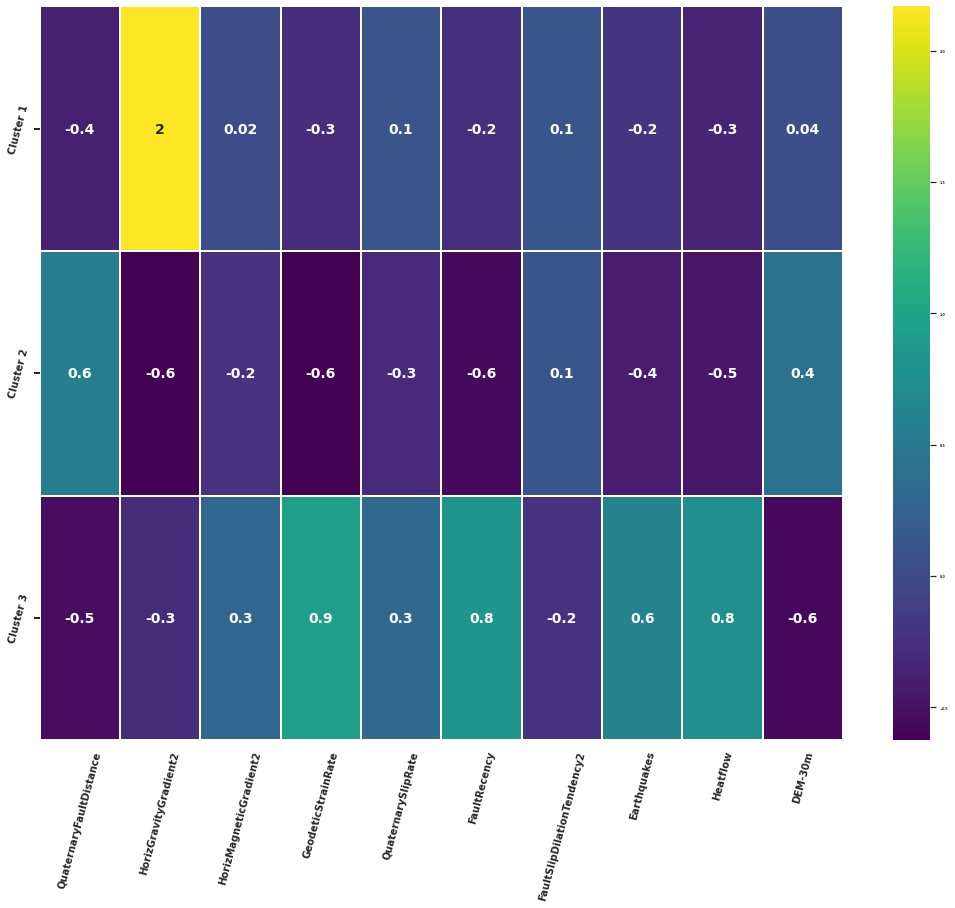

In [ ]:
import seaborn as sns
#we can see influence on each of the components by features.
fig= plt.figure(figsize=(18,13.5))
#PC_Loading_4Sum = PC_Loading_4Sum.transpose()
#H_t= H.transpose()
sns.set(font_scale = 0.3)
#sns.set(weight = 'bold')
ax = sns.heatmap(PC_Loading_4Sum.transpose(),
                 cmap='viridis', linewidths=.95,
                yticklabels=[ "Cluster "+str(FRWY_Set) for FRWY_Set in range(1,nCluster+1)],
                 xticklabels=list(FRWY_Set.columns), 
                 annot=True, annot_kws={"size": 14}, fmt='.1g')
               #  cbar_kws={"orientation": "horizontal"})
ax.tick_params(labelrotation=75,left=True,labelsize = 10, width=-2,)
ax.tick_params(left=True, bottom=True)
from matplotlib import rc, rcParams

rc('font', weight='bold')
ax.set_aspect("equal")
ax.set_title('Fairway PCAk\n  Feature Loading Scores (sum(PC1-PC4))\n' + str(nCluster) + ' clusters -  Feature Set ' + str(feature_set),fontsize=18,fontweight='bold')
#ax.invert_yaxis()
plt.tight_layout
plt.savefig('March_Figs/PCA/TSITES/PCA_SCORES' + str(nCluster) +'Set' + str(feature_set)  +'.png')

### Look at statistics for each cluster

Manually set up constant of the x,y location of the center of each cluster to multiply pca components by to see loading values at centroid

In [ ]:
cluster1 = -0.1

In [ ]:
cluster2 =([[ .2, .2,.2,.2,.2,
             .2,.2,.2,.2,.2],
       [-0.1,-0.1,-0.1,-0.1,-0.1,
        -0.1,-0.1,-0.1,-0.1,-0.1,]])

In [ ]:
cluster3 = 0.07

In [ ]:
cluster4 =([[ -.18, -.18, -.18, -.18, -.18,
         -.18,  -.18, -.18, -.18,  -.18],
       [0.19,0.19,0.19,0.19,0.19,
        0.19,0.19,0.19,0.19,0.19]])

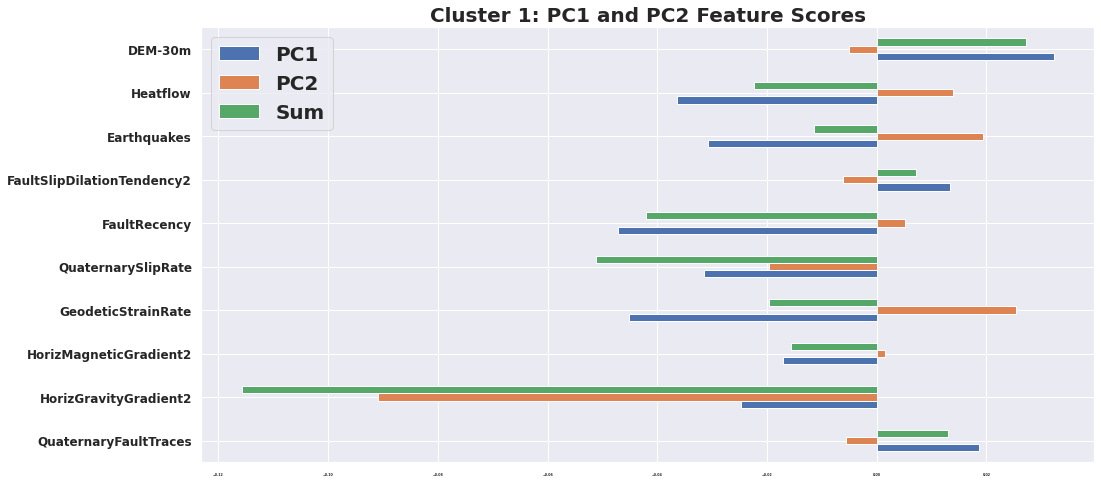

In [ ]:
#Plot scores at the center of a cluster

#select cluster to multiply coefficients by 
aaa = pcamodel.components_[0:2 :]*cluster1
df_columns = ['PC1','PC2']

#set rows to be the feature columns
rows = list(Tsite_Set.columns)
A = pd.DataFrame(aaa.T,rows,df_columns)
A['Sum'] = (A['PC1'])+(A['PC2'])

ax = A.plot(kind='barh')

ax.set_yticklabels(columns, fontweight = 'bold',fontsize=12)

plt.grid(True)
ax.set_title('Cluster 1: PC1 and PC2 Feature Scores',fontweight = 'bold',fontsize=20);
plt.legend(loc='best',fontsize=20);

<function matplotlib.pyplot.tight_layout>

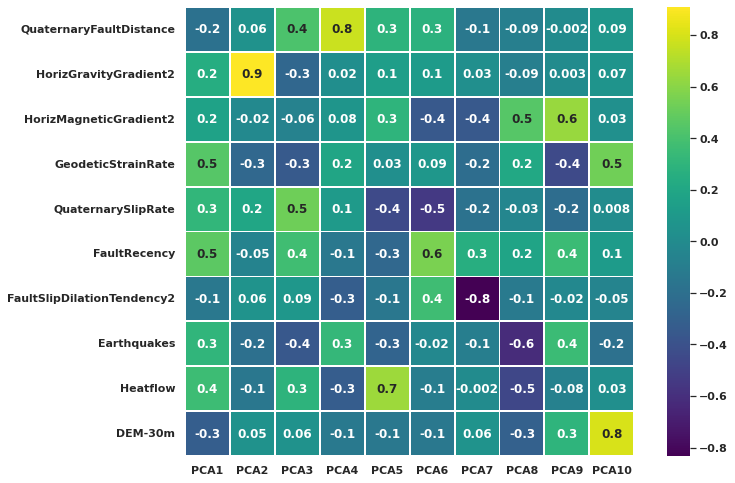

In [ ]:

import seaborn as sns
#we can see influence on each of the components by features.

pcamodel.components_t= pcamodel.components_.transpose()

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.labelsize":20},style="white")
ax = sns.heatmap(pcamodel.components_t,  cmap = 'viridis',
                  linewidths=.95,
                 xticklabels=([ "PCA"+str(FRWY_Set) for FRWY_Set  in range(1,pcamodel.n_components_+1)]),
                 yticklabels=list(FRWY_Set.columns), 
                 annot=True, annot_kws={"size": 12}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})

ax.fontweight='bold'
ax.set_aspect("equal")
plt.tight_layout

### Projection into Fairway

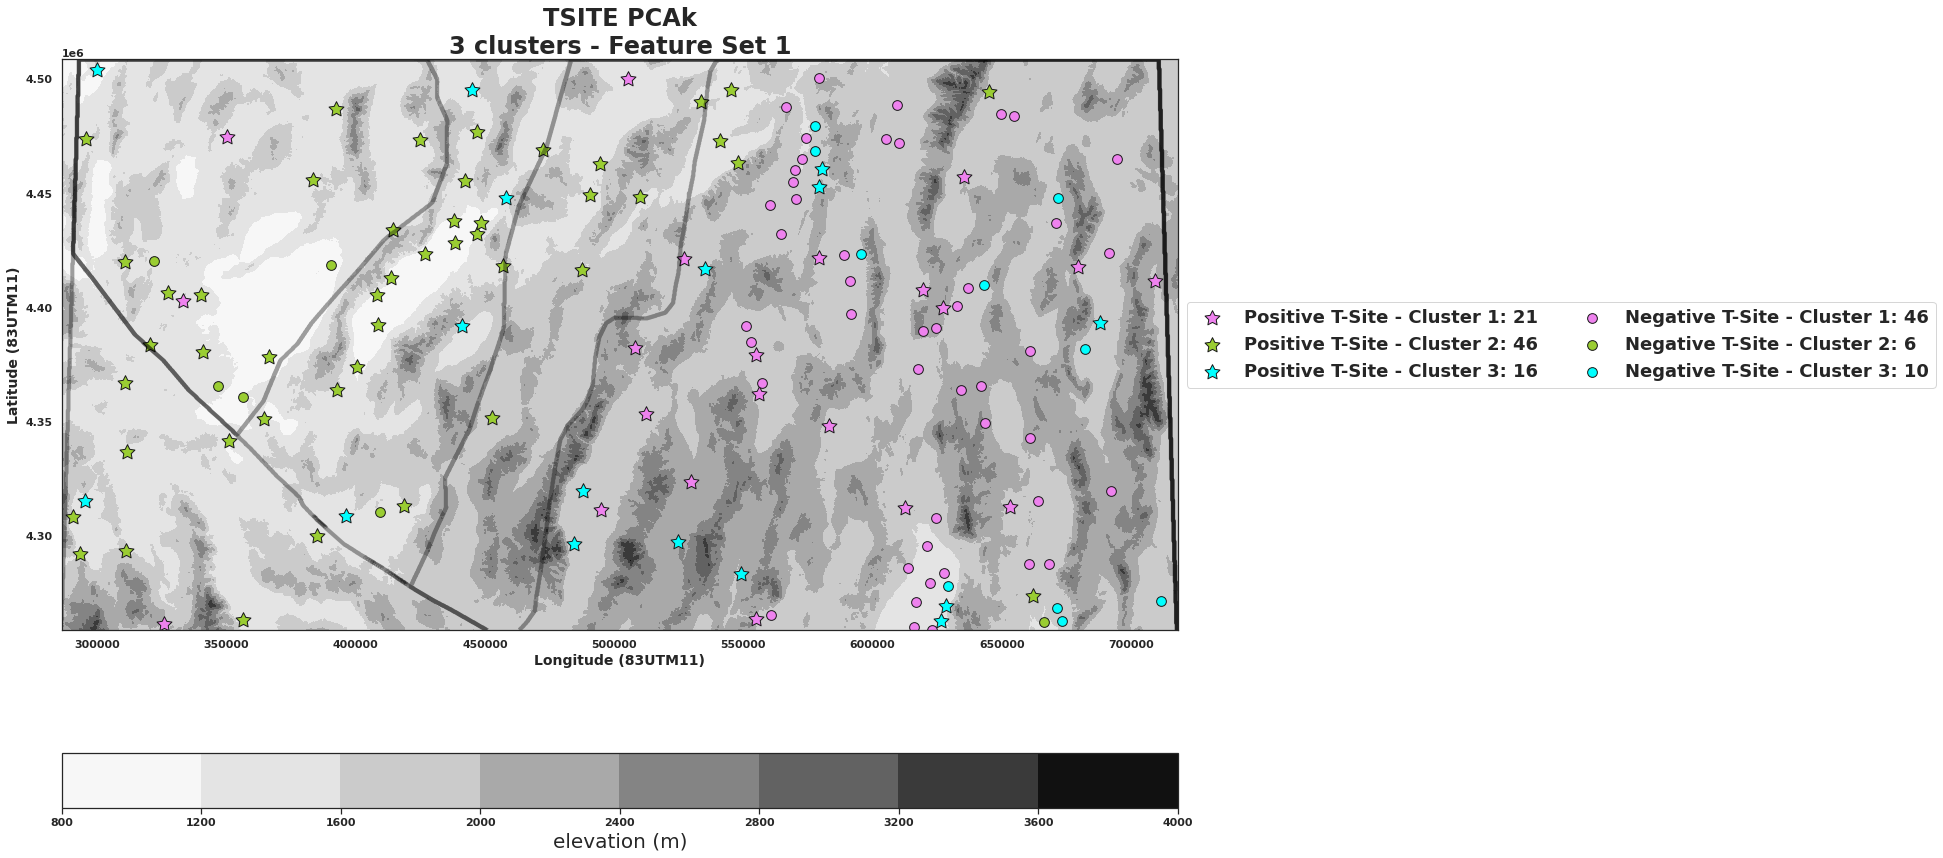

In [ ]:
plt.subplots(figsize=(20,15))

#Set up mesh grid plot for Domains and DEM
a = Info['X_83UTM11']
b = Info['Y_83UTM11']
Domains = Info.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values
DEM = df_features.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values
X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)

plt.contour(Xa,Ya,Domains,colors='black', linewidths=4, alpha=0.2) 

plt.contourf(Xa,Ya,DEM,cmap = 'Greys')
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal')


#Plot positive sites
plt.scatter(group1['X_83UTM11'], group1['Y_83UTM11'],c=c1  ,edgecolors='k', marker=(5, 1),s=245, label=label1)
plt.scatter(group2['X_83UTM11'], group2['Y_83UTM11'], c=c2, edgecolors='k',marker=(5, 1),s=245,label=label2)
plt.scatter(group3['X_83UTM11'], group3['Y_83UTM11'],   c=c3, edgecolors='k',marker=(5, 1),s=245, label=label3)
#plt.scatter(group4['X_83UTM11'], group4['Y_83UTM11'],  c=c4, edgecolors='k',marker=(5, 1),s=245,label=label4)

#Plot negative sites
plt.scatter(group5['X_83UTM11'], group5['Y_83UTM11'], c=c1, marker='o',edgecolors='k',s=95,label=label5)
plt.scatter(group6['X_83UTM11'], group6['Y_83UTM11'],  c=c2, marker='o',edgecolors='k',s=95,label=label6)
plt.scatter(group7['X_83UTM11'], group7['Y_83UTM11'],   c=c3, marker='o',edgecolors='k',s=95,label=label7)
#plt.scatter(group8['X_83UTM11'], group8['Y_83UTM11'],   c=c4, marker='o',edgecolors='k',s=95,label=label8)

ncols = 2
plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', ncol=ncols, bbox_to_anchor=(1, 0.5),fontsize = 18)
plt.grid(True)

plt.title('TSITE PCAk\n' + str(nCluster) + ' clusters - Feature Set ' + str(feature_set),fontsize=24,fontweight='bold');

plt.tight_layout
plt.savefig('March_Figs/PCA/TSITES/PCA_TSITE_MAP' + str(nCluster) +'Set ' + str(feature_set)  +'.png')

## PCA with Domains/Fairway

In [ ]:
from sklearn.decomposition import PCA
n = len(FRWY_Set.columns)
pcamodel = PCA(n_components=n)
pcaFRWY = pcamodel.fit_transform (FRWY_Set)

score= pcaFRWY[:,0:2]



#Index the scores from the PCA reconstruction
xs = score[:,0]
ys = score[:,1]

In [ ]:
#Truncate PCA's if first 4 account for most of the variance
var_ratio1 = float(str(round(pcamodel.explained_variance_ratio_[0]*100, 2)))
var_ratio2 = float(str(round(pcamodel.explained_variance_ratio_[1]*100, 2)))
var_ratio3 = float(str(round(pcamodel.explained_variance_ratio_[2]*100, 2)))
var_ratio4 = float(str(round(pcamodel.explained_variance_ratio_[3]*100, 2)))


### PCA reconstruction for clustering

In [ ]:
"""#Explained variance calcuation

def get_variance(model, data, scorer=metrics.explained_variance_score):
    prediction = model.inverse_transform(model.transform(data)) #Transform data back to original space
    return scorer(data, prediction)

#Get another score? https://scikit-learn.org/stable/modules/model_evaluation.html

#Start at 2 and go up to 8
K = range(2,n,1)

Variance= []
Reconstruction_err = []
Sill_score = []
for k in K:
    pca = PCA(n_components=k).fit(FRWY_Set)
    Variance.append(get_variance(pca,FRWY_Set))
    pcaFRWY = pca.fit_transform(FRWY_Set)
print(Variance)"""

'#Explained variance calcuation\n\ndef get_variance(model, data, scorer=metrics.explained_variance_score):\n    prediction = model.inverse_transform(model.transform(data)) #Transform data back to original space\n    return scorer(data, prediction)\n\n#Get another score? https://scikit-learn.org/stable/modules/model_evaluation.html\n\n#Start at 2 and go up to 8\nK = range(2,n,1)\n\nVariance= []\nReconstruction_err = []\nSill_score = []\nfor k in K:\n    pca = PCA(n_components=k).fit(FRWY_Set)\n    Variance.append(get_variance(pca,FRWY_Set))\n    pcaFRWY = pca.fit_transform(FRWY_Set)\nprint(Variance)'

In [ ]:
"""#Isolate Tsites from W of full fairway for sill score (cant do whole fairway with sill score algorithm)
pcaFRWY_df = pd.DataFrame(pcaFRWY,columns=[ "PC"+str(FRWY_Set) for FRWY_Set in range(1,pca.n_components_+1)])
pca_FRWY_Info = pd.concat([Info,pcaFRWY_df], axis=1, sort=False)
FRWY_Tsites = pca_FRWY_Info[(pca_FRWY_Info['TrainCodePos'] == 1) | (pca_FRWY_Info['TrainCodeNeg'] == 1)]
FRWY_Tsites.drop(FRWY_Tsites[FRWY_Tsites['NullInfo']== 'nullValue'].index, inplace = True) 
FRWY_Tsites_Ws = pd.DataFrame(FRWY_Tsites,columns= ["PC"+str(FRWY_Set) for FRWY_Set in range(1,pca.n_components+1)])
#Truncate to first 4
FRWY_Tsites_Ws = FRWY_Tsites_Ws[['PC1','PC2','PC3','PC4']]
FRWY_Tsites_Ws.reset_index(drop=True, inplace=True) """

'#Isolate Tsites from W of full fairway for sill score (cant do whole fairway with sill score algorithm)\npcaFRWY_df = pd.DataFrame(pcaFRWY,columns=[ "PC"+str(FRWY_Set) for FRWY_Set in range(1,pca.n_components_+1)])\npca_FRWY_Info = pd.concat([Info,pcaFRWY_df], axis=1, sort=False)\nFRWY_Tsites = pca_FRWY_Info[(pca_FRWY_Info[\'TrainCodePos\'] == 1) | (pca_FRWY_Info[\'TrainCodeNeg\'] == 1)]\nFRWY_Tsites.drop(FRWY_Tsites[FRWY_Tsites[\'NullInfo\']== \'nullValue\'].index, inplace = True) \nFRWY_Tsites_Ws = pd.DataFrame(FRWY_Tsites,columns= ["PC"+str(FRWY_Set) for FRWY_Set in range(1,pca.n_components+1)])\n#Truncate to first 4\nFRWY_Tsites_Ws = FRWY_Tsites_Ws[[\'PC1\',\'PC2\',\'PC3\',\'PC4\']]\nFRWY_Tsites_Ws.reset_index(drop=True, inplace=True) '

In [ ]:
"""from sklearn.cluster import MiniBatchKMeans

Sill_score = []
for k in K:
  clusterer = MiniBatchKMeans(n_clusters=k,random_state = RS)
  pred = clusterer.fit_predict(FRWY_Tsites_Ws)
  score = silhouette_score(FRWY_Tsites_Ws, pred)
  Sill_score.append(score)"""

'from sklearn.cluster import MiniBatchKMeans\n\nSill_score = []\nfor k in K:\n  clusterer = MiniBatchKMeans(n_clusters=k,random_state = RS)\n  pred = clusterer.fit_predict(FRWY_Tsites_Ws)\n  score = silhouette_score(FRWY_Tsites_Ws, pred)\n  Sill_score.append(score)'

In [ ]:
"""plt.rc('figure', figsize=(22, 8))

#plt.suptitle('Picking Signals (p) for NMF',fontsize = 38,fontweight='bold')


plt.subplot(121)

plt.bar(K,Variance)
plt.plot(K, Variance, c='r',marker='o')

plt.xlabel('p value  (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Total Explained Variance (0 - 1)',fontsize = 18,fontweight='bold')

plt.title('PCA Signal vs Variance Explained- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

#plt.legend(fontsize = 18)
plt.grid(True)


plt.subplot(122)

plt.plot(K,Sill_score,c='r',marker='o')
plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Sillhouette Score (-1 - 1)',fontsize = 18,fontweight='bold')

plt.title('PCA Signal vs Silhouette Width- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

plt.savefig('March_Figs/PCA/FRWY/PCA_FRWY_find_p_Set ' + str(feature_set) + '.png') """

"plt.rc('figure', figsize=(22, 8))\n\n#plt.suptitle('Picking Signals (p) for NMF',fontsize = 38,fontweight='bold')\n\n\nplt.subplot(121)\n\nplt.bar(K,Variance)\nplt.plot(K, Variance, c='r',marker='o')\n\nplt.xlabel('p value  (2-#features)',fontsize = 18,fontweight='bold')\nplt.ylabel('Total Explained Variance (0 - 1)',fontsize = 18,fontweight='bold')\n\nplt.title('PCA Signal vs Variance Explained- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');\n\n#plt.legend(fontsize = 18)\nplt.grid(True)\n\n\nplt.subplot(122)\n\nplt.plot(K,Sill_score,c='r',marker='o')\nplt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')\nplt.ylabel('Sillhouette Score (-1 - 1)',fontsize = 18,fontweight='bold')\n\nplt.title('PCA Signal vs Silhouette Width- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');\n\nplt.savefig('March_Figs/PCA/FRWY/PCA_FRWY_find_p_Set ' + str(feature_set) + '.png') "

###Look at PCA plots 

<function matplotlib.pyplot.tight_layout>

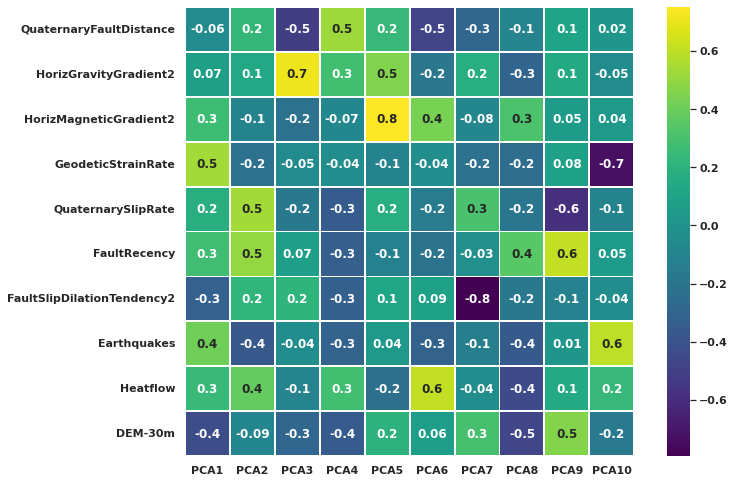

In [ ]:
import seaborn as sns
#we can see influence on each of the components by features.

pcamodel.components_t= pcamodel.components_.transpose()

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.labelsize":20},style="white")
ax = sns.heatmap(pcamodel.components_t,  cmap = 'viridis',
                  linewidths=.95,
                 xticklabels=([ "PCA"+str(FRWY_Set) for FRWY_Set  in range(1,pcamodel.n_components_+1)]),
                 yticklabels=list(FRWY_Set.columns), 
                 annot=True, annot_kws={"size": 12}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})

ax.fontweight='bold'
ax.set_aspect("equal")
plt.tight_layout
#plt.savefig('Figures/PCA/FRWYPCA.png')

#FRWY PCA/NMF

In [ ]:
#from sklearn.decomposition import PCA
#n = len(Xall.columns)
n=2

#pcamodel_FRWY =pcamodel
pca_Xall = pcaFRWY # pcamodel_FRWY.fit_transform(Xall)

In [ ]:
pca_Xall

array([[ 1.06068853e+00, -1.83367857e+00, -7.88351240e-01, ...,
        -1.83927767e+00,  3.92290512e-01,  1.94017785e-03],
       [ 1.12824744e+00, -1.77781280e+00, -5.32308453e-01, ...,
        -1.88803949e+00,  3.89280047e-01,  6.74783834e-03],
       [ 1.22755308e+00, -1.70667525e+00, -2.42847994e-01, ...,
        -1.89641521e+00,  3.33727115e-01,  2.89988608e-02],
       ...,
       [-1.85576407e-16, -2.99279466e-15,  9.49801045e-16, ...,
         1.77258808e-15,  8.27510506e-16, -1.31781984e-15],
       [-1.85576407e-16, -2.99279466e-15,  9.49801045e-16, ...,
         1.77258808e-15,  8.27510506e-16, -1.31781984e-15],
       [-1.85576407e-16, -2.99279466e-15,  9.49801045e-16, ...,
         1.77258808e-15,  8.27510506e-16, -1.31781984e-15]])

In [ ]:
print(sum(pcamodel_FRWY.explained_variance_ratio_))

NameError: ignored

In [ ]:
H = pcamodel.components_
H.shape

In [ ]:
Wall_df= pd.DataFrame(pca_Xall,columns=[ "PC"+str(FRWY_Set) for FRWY_Set in range(1,pcamodel.n_components_+1)])

PCA_W = Wall_df.copy().to_numpy()

In [ ]:
import seaborn as sns
#we can see influence on each of the components by features.
fig= plt.figure(figsize=(18,13.5))
#PC_Loading_4Sum = PC_Loading_4Sum.transpose()
#H_t= H.transpose()
sns.set(font_scale = 1.3)
ax = sns.heatmap(H,
                 cmap='viridis', linewidths=.95,
                yticklabels=[ "PC"+str(n) for n in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(FRWY_Set.columns), 
                 annot=True, annot_kws={"size": 14}, fmt='.1g',)
                # cbar_kws={"orientation": "vertical"})
ax.tick_params(labelrotation=45)               
ax.set_aspect("equal")
ax.set_title("FWY Feature Matrix H",fontsize=18,fontweight='bold')
#ax.invert_yaxis()
plt.tight_layout
plt.savefig('PCAk_Figs/nFairway_'+'PCA_1-3_H_FeatureSet_'+str(feature_set)+'.png')

In [ ]:
img0 = np.reshape(PCA_W[:,0],(1000,-1))
img1 = np.reshape(PCA_W[:,1],(1000,-1))
#img2 = np.reshape(PCA_W[:,2],(1000,-1))
#img3 = np.reshape(PCA_W[:,3],(1000,-1))

"""
img4 = np.reshape(PCA_W[:,4],(1000,-1))
img5 = np.reshape(PCA_W[:,5],(1000,-1))
img6 = np.reshape(PCA_W[:,6],(1000,-1))
img7 = np.reshape(PCA_W[:,7],(1000,-1))
img8 = np.reshape(PCA_W[:,8],(1000,-1))
img9 = np.reshape(PCA_W[:,9],(1000,-1))"""

In [ ]:
PCAmaps = []
for i, columnName in enumerate(Wall_df):
    print (i, columnName)
    im = Wall_df.iloc[:,i].to_numpy().reshape(1000,-1)
 #   im = (im-im.min())
  #  im = im/im.max()
    PCAmaps.append(im)
PCAmaps = np.asarray(PCAmaps)

PCAmaps = np.transpose(PCAmaps, (1, 2, 0))
print(PCAmaps.shape)

In [ ]:
PCAmaps_columns = Wall_df.columns

In [ ]:
fig = plt.figure(figsize=(20,10))

for i in range(0, n):
    ax = fig.add_subplot(2,2, i+1)
    plt.imshow(PCAmaps[:,:,i],origin='lower',cmap ='terrain')
    plt.title(PCAmaps_columns[i])
    plt.axis(False)
   # plt.savefig('PCAk_Figs/nFairway_'+'PCA_1-3_W_FeatureSet_'+str(feature_set)+'.png')

In [ ]:
#See the variance of the first 4 PC's - Truncate at ~60%

"""Look at the percentage of variance explained by the first three or so components
We can make a rough estimate that if we explain ~60% or more of the data in the 
first few PCs we can truncate them""" 

perc = pcamodel.explained_variance_ratio_
print("Total contribution of 1st four components: {} %".format(np.sum(perc[:4])*100))

In [ ]:
#Make a function to plot loading values

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 2.0/(xs.max() - xs.min())
    scaley = 2.0/(ys.max() - ys.min())
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'k',alpha = 0.5, lw = 2 )
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
#            plt.text(coeff[i,0]*0.95, coeff[i,1]*0.95, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, labels[i], color = 'k', ha = 'center', va = 'top',fontsize=13, wrap = False, fontweight = 'semibold')

In [ ]:
#Plot biplot of first 2 PCs
fig= plt.figure(figsize=(15,10.5)) 

scalex = 2.5/(xs.max() - xs.min())
scaley = 2.5/(ys.max() - ys.min())
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())

#plot domain values
plt.scatter(pcaFRWY[Info['Domain']==4,0]*scalex,pcaFRWY[Info['Domain']==4,1]*scalex,color='green',s=55, label='Carb Aq')
plt.scatter(pcaFRWY[Info['Domain']==3,0]*scalex,pcaFRWY[Info['Domain']==3,1]*scalex,color='brown',s=55, label='WGB')
plt.scatter(pcaFRWY[Info['Domain']==1,0]*scalex,pcaFRWY[Info['Domain']==1,1]*scalex,color='cyan',s=55, label='Walker Lane')
plt.scatter(pcaFRWY[Info['Domain']==2,0]*scalex,pcaFRWY[Info['Domain']==2,1]*scalex,color='pink',s=55, label='CNSB')

#plot training sites
plt.scatter(pcaFRWY[Info['TrainCodeNeg']==1,0]*scalex,pcaFRWY[Info['TrainCodeNeg']==1,1]*scalex, color='purple',s=155,edgecolors='k', label='Negative T-Site')
plt.scatter(pcaFRWY[Info['T37']==1,0]*scalex,pcaFRWY[Info['T37']==1,1]*scalex,color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')
plt.scatter(pcaFRWY[Info['TrainCodePosT130']==1,0]*scalex,pcaFRWY[Info['TrainCodePosT130']==1,1]*scalex,color='red',edgecolors='k',s=200,marker=(5, 1),label='Positive T-Site(>130°C)')

#plot loading vectors
myplot(pcaFRWY[:,0:2],np.transpose(pcamodel.components_[0:2 :]),list(FRWY_Set.columns))
plt.legend(scatterpoints=1,loc='center left',bbox_to_anchor=(1, 0.5),fontsize=20)
plt.title('Fairway Set 1 ALT',fontsize=28,fontweight='bold')

var_ratio1 = float(str(round(pcamodel.explained_variance_ratio_[0]*100, 2)))
var_ratio2 = float(str(round(pcamodel.explained_variance_ratio_[1]*100, 2)))

plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)

plt.grid(True)
plt.xlim([-0.8, 0.8])
plt.ylim([-0.8, 0.8])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Make gif

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [ ]:

## ONE ##
plt.scatter(pcaFRWY[Info['Domain']==4,0]*scalex,pcaFRWY[Info['Domain']==4,1]*scalex,color='green',s=55, label='Carb Aq')
plt.scatter(pcaFRWY[Info['Domain']==3,0]*scalex,pcaFRWY[Info['Domain']==3,1]*scalex,color='brown',s=55, label='WGB')
plt.scatter(pcaFRWY[Info['Domain']==1,0]*scalex,pcaFRWY[Info['Domain']==1,1]*scalex,color='cyan',s=55, label='Walker Lane')
plt.scatter(pcaFRWY[Info['Domain']==2,0]*scalex,pcaFRWY[Info['Domain']==2,1]*scalex,color='pink',s=55, label='CNSB')

plt.scatter(pcaFRWY[Info['TrainCodeNeg']==1,0]*scalex,pcaFRWY[Info['TrainCodeNeg']==1,1]*scalex, color='purple',s=55, label='Negative T-Site')
plt.scatter(pcaFRWY[Info['T37']==1,0]*scalex,pcaFRWY[Info['T37']==1,1]*scalex,color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')
plt.scatter(pcaFRWY[Info['TrainCodePosT130']==1,0]*scalex,pcaFRWY[Info['TrainCodePosT130']==1,1]*scalex,color='red',edgecolors='k',s=200,marker=(5, 1),label='Positive T-Site(>130°C)')

myplot(pcaFRWY[:,0:2],np.transpose(pcamodel.components_[0:2 :]),list(FRWY_Set.columns))


plt.xlim([-0.8, 0.8])
plt.ylim([-0.8, 0.8]) 

plt.grid(True)

plt.savefig('March_Figs/PCA/FRWYbiplot.png')
plt.show()
## TWO ##
plt.scatter(pcaFRWY[Info['Domain']==4,0]*scalex,pcaFRWY[Info['Domain']==4,1]*scalex,color='green',s=55, label='Carb Aq')
plt.scatter(pcaFRWY[Info['TrainCodeNeg']==1,0]*scalex,pcaFRWY[Info['TrainCodeNeg']==1,1]*scalex, color='purple',s=55, label='Negative T-Site')
plt.scatter(pcaFRWY[Info['T37']==1,0]*scalex,pcaFRWY[Info['T37']==1,1]*scalex,color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')
plt.scatter(pcaFRWY[Info['TrainCodePosT130']==1,0]*scalex,pcaFRWY[Info['TrainCodePosT130']==1,1]*scalex,color='red',edgecolors='k',s=200,marker=(5, 1),label='Positive T-Site(>130°C)')

myplot(pcaFRWY[:,0:2],np.transpose(pcamodel.components_[0:2 :]),list(FRWY_Set.columns))


plt.xlim([-0.8, 0.8])
plt.ylim([-0.8, 0.8])
plt.grid(True)
plt.savefig('March_Figs/PCA/CARB.png')
plt.show()

## THREE ##
plt.scatter(pcaFRWY[Info['Domain']==3,0]*scalex,pcaFRWY[Info['Domain']==3,1]*scalex,color='brown',s=55, label='WGB')
plt.scatter(pcaFRWY[Info['TrainCodeNeg']==1,0]*scalex,pcaFRWY[Info['TrainCodeNeg']==1,1]*scalex, color='purple',s=55, label='Negative T-Site')
plt.scatter(pcaFRWY[Info['T37']==1,0]*scalex,pcaFRWY[Info['T37']==1,1]*scalex,color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')
plt.scatter(pcaFRWY[Info['TrainCodePosT130']==1,0]*scalex,pcaFRWY[Info['TrainCodePosT130']==1,1]*scalex,color='red',edgecolors='k',s=200,marker=(5, 1),label='Positive T-Site(>130°C)')

myplot(pcaFRWY[:,0:2],np.transpose(pcamodel.components_[0:2 :]),list(FRWY_Set.columns))

plt.xlim([-0.8, 0.8])
plt.ylim([-0.8, 0.8])

plt.grid(True)
plt.savefig('March_Figs/PCA/WGB.png')
plt.show()

## FOUR ##
plt.scatter(pcaFRWY[Info['Domain']==1,0]*scalex,pcaFRWY[Info['Domain']==1,1]*scalex,color='cyan',s=55, label='Walker Lane')
plt.scatter(pcaFRWY[Info['TrainCodeNeg']==1,0]*scalex,pcaFRWY[Info['TrainCodeNeg']==1,1]*scalex, color='purple',s=55, label='Negative T-Site')
plt.scatter(pcaFRWY[Info['T37']==1,0]*scalex,pcaFRWY[Info['T37']==1,1]*scalex,color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')
plt.scatter(pcaFRWY[Info['TrainCodePosT130']==1,0]*scalex,pcaFRWY[Info['TrainCodePosT130']==1,1]*scalex,color='red',edgecolors='k',s=200,marker=(5, 1),label='Positive T-Site(>130°C)')

myplot(pcaFRWY[:,0:2],np.transpose(pcamodel.components_[0:2 :]),list(FRWY_Set.columns))


plt.xlim([-0.8, 0.8])
plt.ylim([-0.8, 0.8])

plt.grid(True)
plt.savefig('March_Figs/PCA/WL.png')
plt.show()

## FIVE ##
plt.scatter(pcaFRWY[Info['Domain']==2,0]*scalex,pcaFRWY[Info['Domain']==2,1]*scalex,color='pink',s=55, label='CNSB')
plt.scatter(pcaFRWY[Info['TrainCodeNeg']==1,0]*scalex,pcaFRWY[Info['TrainCodeNeg']==1,1]*scalex, color='purple',s=55, label='Negative T-Site')
plt.scatter(pcaFRWY[Info['T37']==1,0]*scalex,pcaFRWY[Info['T37']==1,1]*scalex,color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')
plt.scatter(pcaFRWY[Info['TrainCodePosT130']==1,0]*scalex,pcaFRWY[Info['TrainCodePosT130']==1,1]*scalex,color='red',edgecolors='k',s=200,marker=(5, 1),label='Positive T-Site(>130°C)')

myplot(pcaFRWY[:,0:2],np.transpose(pcamodel.components_[0:2 :]),list(FRWY_Set.columns))

plt.xlim([-0.8, 0.8])
plt.ylim([-0.8, 0.8])

plt.grid(True)
plt.savefig('March_Figs/PCA/CNSB.png')
plt.show()

#plt.title('Fairway Set 1 ALT',fontsize=28,fontweight='bold')



In [ ]:
# Build GIF
with imageio.get_writer('mygif.gif', mode='I', fps = 0.4) as writer:
    for filename in ['March_Figs/PCA/FRWYbiplot.png', 'March_Figs/PCA/CARB.png', 'March_Figs/PCA/WGB.png', 'March_Figs/PCA/WL.png','March_Figs/PCA/CNSB.png']:
        image = imageio.imread(filename)
        writer.append_data(image)

### PCA reconstruction for clustering

In [ ]:
startIndex = 0
plt.figure(figsize=(10,6))
plt.plot(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_,c='r',marker='o')
#plt.grid()
xposition = [4]
for xc in xposition:
    plt.axvline(x=xc, color='red', linestyle='--')
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_) #width=0.5

plt.ylabel('Explained Variance Ratio (0 - 1)',fontsize = 18,fontweight='bold')
plt.xlabel('Components',fontsize = 18,fontweight='bold')
plt.title('PC vs Variance Explained - Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');


plt.savefig('March_Figs/PCA/FRWY/PCA_FRWY_VarEx ' + str(feature_set) + '.png') 

In [ ]:
#Add PC's to info dataframe
pcaFRWY_df = pd.DataFrame(pcaFRWY,columns=[ "PC"+str(FRWY_Set) for FRWY_Set in range(1,pcamodel.n_components_+1)])
Info = pd.concat([Info,pcaFRWY_df], axis=1, sort=False)

In [ ]:
#evaluate optimal cluster number for k means
plt.figure(figsize=(10,6))
from sklearn.cluster import MiniBatchKMeans

distortions = []
for i in range(1, 9):
    km = MiniBatchKMeans(n_clusters=i, init = 'k-means++',random_state=RS) 

    #K-means on the first 4 or so PCs which explain the most variance
    km.fit(Info[['PC1','PC2','PC3','PC4']])
    distortions.append(km.inertia_)


xposition = [3]
for xc in xposition:
    plt.axvline(x=xc, color='red', linestyle='--')
 
# plot
#plt.plot(figsize =(10,10))
plt.plot(range(1, 9), distortions, marker='o')
plt.xlabel('Number of clusters',fontsize = 18,fontweight='bold')
plt.ylabel('Within-Group Sum of Squares',fontsize = 18,fontweight='bold')
#plt.grid()
plt.title('Cluster # vs WSS- Feature Set '+ str(feature_set) ,fontsize = 22,fontweight='bold')

plt.savefig('March_Figs/PCA/FRWY/PCA_FRWY_PickCluster ' + str(feature_set) + '.png');

### PCA Kmeans clustering

In [ ]:
RS

In [ ]:
#Kmeans
from sklearn.cluster import MiniBatchKMeans

FRWY_reset = Info.reset_index( drop=True,inplace = False, col_level=0, col_fill='')
FW = pd.DataFrame(FRWY_reset)
cols = FW.columns


nCluster = 3

Kmean = MiniBatchKMeans(n_clusters=nCluster, init = 'k-means++', verbose = 0,random_state=None)

Kmean.fit(pcaFRWY_df[['PC1','PC2','PC3','PC4']])

In [ ]:
centers = np.copy(Kmean.cluster_centers_)
print('centers.ndim: {}'.format(centers.ndim))
print('centers.shape: {}'.format(centers.shape))
print('centers.size: {}'.format(centers.size))
print(centers)

Labels = Kmean.labels_

In [ ]:
df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1],
                          'Grp2_CntrX':centers[2,0],
                          'Grp2_CntrY':centers[1,2]})
 #                         'Grp3_CntrX':centers[3,0],
 #                         'Grp3_CntrY':centers[1,3]})

df_out = pd.concat([Info, df_labels], axis=1, sort=False)

print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
print('', file=sys.stdout, flush=True)

In [ ]:
#Groups for the fairway
group1 = df_out[df_out['KMeansGrp']==0]
label1 = 'Cluster 1'
group2 = df_out[df_out['KMeansGrp']==1]
label2 = 'Cluster 2'
group3 = df_out[df_out['KMeansGrp']==2]
label3 = 'Cluster 3'
group4 = df_out[df_out['KMeansGrp']==3]
label4 = 'Cluster 4'

#Groups for positive sites
group5 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)]
label5 = 'Positive T-Site - Cluster 1 ' + str(len(group5))
group6 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)]
label6 = 'Positive T-Site - Cluster 2: ' + str(len(group6))
group7 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)]
label7 = 'Positive T-Site - Cluster 3: ' + str(len(group7))
group8 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 3)]
label8 = 'Positive T-Site - Cluster 4: ' + str(len(group8))

#Groups for negative sites 
group9 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]
label9 = 'Negative T-Site - Cluster 1: ' + str(len(group9))
group10 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]
label10 = 'Negative T-Site - Cluster 2: ' + str(len(group10))
group11 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]
label11 = 'Negative T-Site - Cluster 3: ' + str(len(group11))
group12 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 3)]
label12 = 'Negative T-Site - Cluster 4: ' + str(len(group12))

#Groups for each structure within each k means
group13 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 0)]
label13 = 'str - cluster 1'
group14 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 1)]
label14 = 'str - cluster 2'
group15 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 2)]
label15 = 'str - cluster 3'
group16 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 3)]
label16 = 'str - cluster 4'

In [ ]:
#ADD VECTORS
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*10, coeff[i,1]*10,color = 'k',alpha = 0.5, lw = 2 ) #MULTIPLY BY 10
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 10.00, coeff[i,1] * 10.00, labels[i],color = 'k',horizontalalignment='center', verticalalignment='center_baseline', fontsize=15,fontweight='bold')


In [ ]:
c1 = 'violet'
c2 =  'yellowgreen'
c3 ='cyan'  
c4 ='yellowgreen'

In [ ]:
#Plot biplot with k means groups

plt.subplots(figsize=(20,14.5))

plt.scatter(group1['PC1'], group1['PC2'], c=c1,s=0.5,marker='.')
plt.scatter(group2['PC1'], group2['PC2'],c=c2, s=0.5,marker='.')
plt.scatter(group3['PC1'], group3['PC2'], c=c3,s=0.5,marker='.')
plt.scatter(group4['PC1'], group4['PC2'], c=c4,s=0.5,marker='.')


plt.scatter(group5['PC1'], group5['PC2'], c=c1,edgecolors='k',s=385, marker=(5, 1),label=label5)
plt.scatter(group6['PC1'], group6['PC2'],c=c2, edgecolors='k',s=385, marker=(5, 1), label=label6) 
plt.scatter(group7['PC1'], group7['PC2'],c=c3,edgecolors='k',s=385, marker=(5, 1),label=label7)
plt.scatter(group8['PC1'], group8['PC2'], c=c4,edgecolors='k',s=385, marker=(5, 1),label=label8)



plt.scatter(group9['PC1'], group9['PC2'], c=c1,edgecolors='k',s=85,marker='o', label=label9)
plt.scatter(group10['PC1'], group10['PC2'],c=c2,edgecolors='k',s=85,marker='o', label=label10)
plt.scatter(group11['PC1'], group11['PC2'],c=c3 , edgecolors='k',s=85,marker='o', label=label11) 
plt.scatter(group12['PC1'], group12['PC2'], c=c4,edgecolors='k',s=85,marker='o', label=label12)


#Plot Kmeans center locations
plt.scatter(centers[:,0] , centers[:,1] , s = 380, marker='o', edgecolors='k',color = 'white')
for i in range(centers.shape[0]):
    plt.text(centers[i,0], centers[i,1], str(i+1),fontsize=12,fontweight='bold',horizontalalignment='center', verticalalignment='center')


#plt.xlim([-5, 7])
plt.ylim([-8, 8]) 

myplot(pcaFRWY[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(FRWY_Set.columns))

#Plot Kmeans center locations
plt.scatter(centers[:,0] , centers[:,1] , s = 380, marker='o', edgecolors='k',color = 'white')


plt.title('Fairway PCAk Biplot\n' + str(nCluster) + ' clusters -  Feature Set '+ str(feature_set),fontsize=24,fontweight='bold');

ncols = 2
plt.legend(loc='center left',ncol=ncols, bbox_to_anchor=(1, 0.5))

plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)

ax.set_facecolor('white')
plt.grid(True)


plt.savefig('March_Figs/PCA/FRWY/Biplot_FRWY_PCA' + str(nCluster) +'Set' + str(feature_set)  + '.png')

### Look at statistics for each cluster

Manually set up constant of the x,y location of the center of each cluster to multiply pca components by to see loading values at centroid

In [ ]:
[[-1.15383637 -0.05192407  0.09688891 -0.06547667]
 [ 1.0943028  -1.01897831 -0.05018825  0.05699701]
 [ 0.95608727  1.39714033 -0.14901548  0.04984449]]

In [ ]:
Centers = centers

C1_Center = Centers[0:1].T
C2_Center = Centers[1:2].T
C3_Center = Centers[2:3].T
C4_Center = Centers[3:4].T

In [ ]:
#Find the values for PC1-PC4 for each cluster

plt.rc('figure', figsize=(16, 8))

#plt.suptitle('Picking Signals (p) for NMF',fontsize = 38,fontweight='bold')



#select cluster to multiply coefficients by 
Cluster1_results = pcamodel.components_[0:4 :]*C1_Center
Cluster2_results = pcamodel.components_[0:4 :]*C2_Center
Cluster3_results = pcamodel.components_[0:4 :]*C3_Center
#Cluster4_results = pcamodel.components_[0:4 :]*C4_Center

df_columns = ['PC1','PC2','PC3','PC4']

#set rows to be the feature columns
rows = list(FRWY_Set.columns)
C1_DF = pd.DataFrame(Cluster1_results.T,rows,df_columns)
C1_DF['Cluster1'] = (C1_DF['PC1'])+(C1_DF['PC2']+C1_DF['PC3']+C1_DF['PC4'])

C2_DF = pd.DataFrame(Cluster2_results.T,rows,df_columns)
C2_DF['Cluster2'] = (C2_DF['PC1'])+(C2_DF['PC2']+C2_DF['PC3']+C2_DF['PC4'])

C3_DF = pd.DataFrame(Cluster3_results.T,rows,df_columns)
C3_DF['Cluster3'] = (C3_DF['PC1'])+(C3_DF['PC2']+C3_DF['PC3']+C3_DF['PC4'])

#C4_DF = pd.DataFrame(Cluster4_results.T,rows,df_columns)
#C4_DF['Cluster4'] = (C4_DF['PC1'])+(C4_DF['PC2']+C4_DF['PC3']+C4_DF['PC4'])


c1 ='violet'
c2 ='yellowgreen' 
c3 ='cyan' 

#plt.subplot(221)

ax = C3_DF['Cluster3'].plot(kind='barh',color = c2,alpha =0.8)
ax = C1_DF['Cluster1'].plot(kind='barh',color = c1,alpha = 0.6)
ax = C2_DF['Cluster2'].plot(kind='barh',color = c3,alpha = 0.4)
#ax = C4_DF['Cluster4'].plot(kind='barh',color = c4,alpha = 0.5)

ax.set_yticklabels(FRWY_Set.columns, fontweight = 'bold',fontsize=15)
plt.grid(True)
plt.legend(loc='best',fontsize=20);

ax.set_title('Fairway PCAk Feature Loading Scores (sum(PC1-PC4))\n' + str(nCluster) + ' clusters -  Feature Set ' + str(feature_set),fontsize=24,fontweight='bold'); 

In [ ]:
C1_DF['Cluster2']=C2_DF['Cluster2']
C1_DF['Cluster3']=C3_DF['Cluster3']
C1_DF.columns
C1_DF_columns = ['Cluster1', 'Cluster2', 'Cluster3']
PC_Loading_4Sum = C1_DF.copy()[C1_DF_columns]

In [ ]:
import seaborn as sns
#we can see influence on each of the components by features.
fig= plt.figure(figsize=(18,13.5))
#PC_Loading_4Sum = PC_Loading_4Sum.transpose()
#H_t= H.transpose()
sns.set(font_scale = 1.3)
ax = sns.heatmap(PC_Loading_4Sum.transpose(),
                 cmap='viridis', linewidths=.95,
                yticklabels=[ "Cluster "+str(FRWY_Set) for FRWY_Set in range(1,nCluster+1)],
                 xticklabels=list(FRWY_Set.columns), 
                 annot=True, annot_kws={"size": 14}, fmt='.1g',)
               #  cbar_kws={"orientation": "horizontal"})
ax.tick_params(labelrotation=45)               
ax.set_aspect("equal")
ax.set_title('Fairway PCAk\n  Feature Loading Scores (sum(PC1-PC4))\n' + str(nCluster) + ' clusters -  Feature Set ' + str(feature_set),fontsize=18,fontweight='bold')
#ax.invert_yaxis()
plt.tight_layout
plt.savefig('March_Figs/PCA/FRWY/PCA_SCORES' + str(nCluster) +'Set' + str(feature_set)  +'.png')

### Projection into Fairway

In [ ]:
c3 = 'cyan' 
c1 ='violet'
c2 = 'yellowgreen'

#1-violet, 2-yg, 3-cyan

In [ ]:
plt.subplots(figsize=(20,15))

#Set up mesh grid plot for Domains and DEM
a = Info['X_83UTM11']
b = Info['Y_83UTM11']
Domains = Info.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values
DEM = df_features.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values
X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)

plt.contour(Xa,Ya,Domains,colors='black', linewidths=4, alpha=0.2) 

plt.contourf(Xa,Ya,DEM,cmap = 'Greys')
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal')

#Plot all points
plt.scatter(group1['X_83UTM11'], group1['Y_83UTM11'],c=c1 ,marker='.',s=0.05,alpha = 0.5)
plt.scatter(group2['X_83UTM11'], group2['Y_83UTM11'],c=c2, marker='.',s=0.05, alpha = 0.5)
plt.scatter(group3['X_83UTM11'], group3['Y_83UTM11'], c=c3, marker='.',s=0.05, alpha = 0.5)
plt.scatter(group4['X_83UTM11'], group4['Y_83UTM11'],  c=c4, marker='.',s=0.05,alpha = 0.5)

#Plot structures
#plt.scatter(group13['X_83UTM11'], group13['Y_83UTM11'], c=c1,s=1,marker='.',alpha = 0.4, label=label13)
#plt.scatter(group14['X_83UTM11'], group14['Y_83UTM11'], c=c2,s=1,marker='.',alpha = 0.4, label=label14)
#plt.scatter(group15['X_83UTM11'], group15['Y_83UTM11'], c=c3,s=1,marker='.',alpha = 0.4, label=label15)
#plt.scatter(group16['X_83UTM11'], group16['Y_83UTM11'], c='darkred',s=1,marker='.',alpha = 0.4, label=label16)

#Plot positive sites
plt.scatter(group5['X_83UTM11'], group5['Y_83UTM11'],  c=c1,edgecolors='k', marker=(5, 1),s=245, label=label5)
plt.scatter(group6['X_83UTM11'], group6['Y_83UTM11'], c=c2, edgecolors='k',marker=(5, 1),s=245,label=label6)
plt.scatter(group7['X_83UTM11'], group7['Y_83UTM11'],  c=c3 , edgecolors='k',marker=(5, 1),s=245, label=label7)
#plt.scatter(group8['X_83UTM11'], group8['Y_83UTM11'],  c=c4, edgecolors='k',marker=(5, 1),s=245,label=label8)

#Plot negative sites
plt.scatter(group9['X_83UTM11'], group9['Y_83UTM11'], c=c1 , marker='o',edgecolors='k',s=95,label=label9)
plt.scatter(group10['X_83UTM11'], group10['Y_83UTM11'], c=c2, marker='o',edgecolors='k',s=95,label=label10)
plt.scatter(group11['X_83UTM11'], group11['Y_83UTM11'], c=c3, marker='o',edgecolors='k',s=95,label=label11)
#plt.scatter(group12['X_83UTM11'], group12['Y_83UTM11'],  c=c4, marker='o',edgecolors='k',s=95,label=label12)

ncols = 2
plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', ncol=ncols, bbox_to_anchor=(1, 0.5),fontsize = 18)

#plt.grid(True)

plt.title('Fairway PCAk\n' + str(nCluster) + ' clusters -  Feature Set ' + str(feature_set),fontsize=24,fontweight='bold');

plt.tight_layout
plt.savefig('March_Figs/PCA/FRWY/PCA_FRWY' + str(nCluster) +'Set' + str(feature_set)  +'.png')

In [ ]:
df_cluster = df_out['KMeansGrp']

df_cluster = df_cluster.copy().to_numpy()

img0 = np.reshape(df_cluster,(1000,-1))

#df_cluster.to_numpy().reshape(1000,-1)
#img0 = np.reshape(df_cluster,(1000,-1))

img0.shape


In [ ]:
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(12,12))
im = plt.imshow(img0, origin='lower', cmap = 'rainbow'
# norm=colors.Normalize(vmin=0.0, vmax=1.0)
# norm=colors.SymLogNorm(linthresh=0.3, linscale=0.3, vmin=-1.0, vmax=1.0, base=10))
)
plt.title('PCA-Kmeans',fontsize = 24)
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.1)
#cb = plt.colorbar(im, cax=cax)
#cb.set_label('feature value',fontsize=16)
ax.grid(False)

## save maps as geotiffs

In [ ]:
import osgeo.gdal as gdal

import osgeo.osr as osr

In [ ]:
transform = [286202.6902, 250.0, 0.0, 4508588.7659, 0.0, -250.0]

In [ ]:
img0 = np.flipud(img0)
# img1 = np.flipud(imgm)
# img2 = np.flipud(imgmax)

In [ ]:
height = img0.shape[0]
width = img0.shape[1]
print (width, height)

In [ ]:
# open a new file
geotiffFile = 'PCAk_Figs/PCA_1-3_k_FeatureSet_'+str(feature_set)+'.tif'

driver = gdal.GetDriverByName("GTiff")
outRaster = driver.Create(geotiffFile, width, height, 1, gdal.GDT_Float32)

# use PFA's geo-transform found above
outRaster.SetGeoTransform(transform)

# assign color band
outband = outRaster.GetRasterBand(1)
outband.WriteArray(img0)

# set coordinate reference system
outRasterSRS = osr.SpatialReference() # create instance of class
outRasterSRS.ImportFromEPSG(26911)    # set to specific coordinate reference system
# outRasterSRS.ImportFromWkt(raster.GetProjectionRef()) # or could use SRS from before
outRaster.SetProjection(outRasterSRS.ExportToWkt()) # set the projection

# flush output to file
outband.FlushCache()

# this closes the files
raster = None
outRaster = None

